# **Using Residual Sugar, Citric Acid and Volatile Acidity to judge a wine's quality.**
#### Leewana Nanda,
#### Arjun Bhatia (79462032)
#### Maya Tharp, 
#### Sue Dong

## Introduction


Wine quality can be determined by a number of factors, ranging from physicochemical properties, such as residual
sugar, to sensory properties, like aroma, color and flavor. However, it is the interaction between the 
physicochemical properties and the sensory properties that allows for a judgment to be made regarding the quality
of the wine (Gutiérrez-Escobar et al., 2021). This project will investigate if physicochemical properties of sweet
red wine can predict the quality of the red wine. The dataset chosen is “Wine Quality” from UC Irvine and it is a 
multivariate dataset. The dataset has twelve variables in total, including the target “quality” variable and looks
at several physicochemical properties. 

Hypothesis: Higher levels of indicators of sweetness (volatile acidity, residual sugar, citric acid) correspond to higher quality and these 3 can be used to accurately predict the quality of a wine. 

[provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report,
clearly state the question you tried to answer with your project,
identify and describe the dataset that was used to answer the question]



## Methods

###  Importing libraries

In [139]:
install.packages("kknn")
install.packages("themis")
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 10, repr.plot.height = 7)
library(themis)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



....

###  Reading the data

In [141]:
#Reading the data fom the URL 
wine_data <- read.csv2("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")

wine_data 

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.51,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11,6
5.9,0.645,0.12,2,0.075,32,44,0.99547,3.57,0.71,10.2,5
6,0.31,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11,6


Observations about data

###  Plotting the frequency of qualities in the dataset

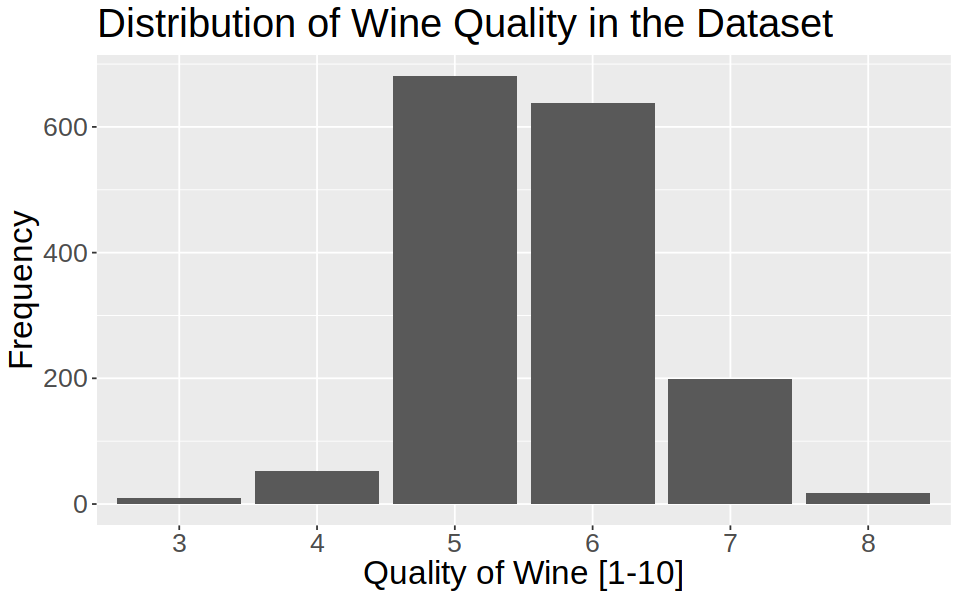

In [150]:
set.seed(1311)
options(repr.plot.width = 8, repr.plot.height = 5)

quality_distribution <- wine_data |>
                        ggplot(aes(x = quality)) +
                        geom_bar() +
                        labs(x = "Quality of Wine [1-10]", y = "Frequency") +
                        ggtitle("Distribution of Wine Quality in the Dataset") +
                        theme(text = element_text(size = 20))

quality_distribution

Inference drawn from graph here

###  Selecting the parameters we need and converting them from 'chr' to 'numeric' and 'factor'

In [143]:
set.seed(1311)
wine_data <- wine_data |> 
             select(volatile.acidity, citric.acid, residual.sugar, quality)|>
             mutate(volatile.acidity = as.numeric(volatile.acidity)) |>
             mutate(citric.acid = as.numeric(citric.acid)) |>
             mutate(residual.sugar = as.numeric(residual.sugar)) |>
             mutate(quality = as.factor(quality))

str(wine_data)

'data.frame':	1599 obs. of  4 variables:
 $ volatile.acidity: num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid     : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar  : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ quality         : Factor w/ 6 levels "3","4","5","6",..: 3 3 3 4 3 3 3 5 5 3 ...


Explain

### Scaling and centering wine data

In [144]:
set.seed(1311)
wine_recipe <- recipe(quality ~ ., data = wine_data)|>
               step_scale(all_predictors()) |>
               step_center(all_predictors())|>
               prep()
wine_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Training data contained 1599 data points and no missing data.

Operations:

Scaling for volatile.acidity, citric.acid, residual.sugar [trained]
Centering for volatile.acidity, citric.acid, residual.sugar [trained]

In [151]:
wine_scaled <- bake(wine_recipe, wine_data)
wine_scaled

volatile.acidity,citric.acid,residual.sugar,quality
<dbl>,<dbl>,<dbl>,<fct>
0.7349068,-0.02590112,1.931304,5
0.9183559,-0.02590112,2.642374,5
0.7960565,0.01392343,2.337630,5
⋮,⋮,⋮,⋮
0.5412661,0.10352867,2.337630,6
0.6788529,0.09357253,2.032885,5
0.3374337,0.44203736,3.658189,6


### Classification based on 3 predictors:

In [152]:
#Splitting the data set into training and testing
set.seed(1311)

wine_split <- initial_split(wine_scaled, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

In [153]:
#Creating classification recipe and spec
set.seed(1311)

wine_recipe <- recipe(quality ~ . , data = wine_training)|>
               step_center(all_predictors())|>
               step_scale(all_predictors())|>
               prep()

wine_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
             set_engine("kknn") |>
             set_mode("classification")

wine_recipe
wine_tune

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Training data contained 1198 data points and no missing data.

Operations:

Centering for volatile.acidity, citric.acid, residual.sugar [trained]
Scaling for volatile.acidity, citric.acid, residual.sugar [trained]

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [166]:
#Choosing the optimal number of neighbours 
set.seed(1311)
options(repr.plot.width = 8, repr.plot.height = 5)

wine_vfold <- vfold_cv(wine_training, v = 5, strata = quality)

knn_results <- workflow() |>
               add_recipe(wine_recipe) |>
               add_model(wine_tune) |>
               tune_grid(resamples = wine_vfold, grid = 10)|>
               collect_metrics()
knn_results

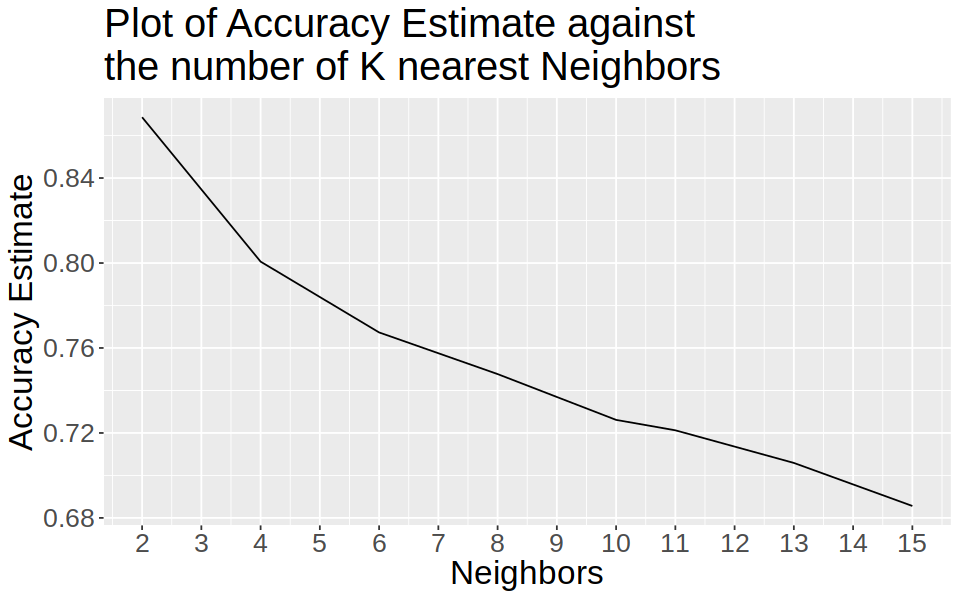

In [167]:
set.seed(1311)
#Plotting predicted accuracies to choose optimal number of neighbors

accuracies <- knn_results |> 
              filter(.metric == "accuracy")

accuracies_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
                   geom_line() +
                   labs(x = "Neighbors", y = "Accuracy Estimate", title = "Plot of Accuracy Estimate against
the number of K nearest Neighbors") +
                   scale_x_continuous(breaks = seq(0, 100, by = 1)) +  
                   theme(text = element_text(size = 20)) 

accuracies_plot

Talk about low predicted accuracy

In [168]:
## Running the classification model on training data
set.seed(1311)

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
             set_engine("kknn") |>
             set_mode("classification")

wine_fit <- workflow()|>
            add_recipe(wine_recipe)|>
            add_model(wine_spec)|>
            fit(data = wine_training)

wine_spec
wine_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 2
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1611111
Best kernel: rectangular
Best k: 2

In [169]:
#Checking against the testing data
set.seed(1311)
wine_predictions <- wine_fit|>
                    predict(wine_testing)|>
                    bind_cols(wine_testing)|>
                    metrics(truth = quality, estimate = .pred_class)|>
                    filter(.metric == "accuracy")
wine_predictions


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8947368


Accuracy is too low

Possible reasons:

1) Wrong hypothesis
2) Too little data
3) Unbalanced data

### Upsampling the dataset

In [174]:
# Non-Upsampled data
wine_scaled|>
  group_by(quality)|>
  summarize(n = n())

quality,n
<fct>,<int>
3,10
4,53
5,681
6,638
7,199
8,18


Talk about why we need to upsample

In [176]:
set.seed(1311)
#Upsampling scaled data to account for variance
ups_recipe <- recipe(quality ~ ., data = wine_scaled) |>
  step_upsample(quality, over_ratio = 1, skip = FALSE) |>
  prep()

upsampled_wine <- bake(ups_recipe, wine_scaled)

# Upsampled data
upsampled_wine |>
  group_by(quality) |>
  summarize(n = n())

quality,n
<fct>,<int>
3,681
4,681
5,681
6,681
7,681
8,681


Talk about diff

### Classification using upsampled data

In [177]:
#Splitting the data set into training and testing
set.seed(1311)

wine_split <- initial_split(upsampled_cancer, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

In [178]:
#Creating classification recipe and spec
set.seed(1311)

wine_recipe <- recipe(quality ~ . , data = wine_training)|>
               step_center(all_predictors())|>
               step_scale(all_predictors())|>
               prep()

wine_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
             set_engine("kknn") |>
             set_mode("classification")

wine_recipe
wine_tune


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Training data contained 3060 data points and no missing data.

Operations:

Centering for volatile.acidity, citric.acid, residual.sugar [trained]
Scaling for volatile.acidity, citric.acid, residual.sugar [trained]

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [179]:
# V-fold and knn tune setup
set.seed(1311)

wine_vfold <- vfold_cv(wine_training, v = 5, strata = quality)


In [180]:
# Choosing the optimal number of neighbors for classification
set.seed(1311)

knn_results <- workflow() |>
               add_recipe(wine_recipe) |>
               add_model(wine_tune) |>
               tune_grid(resamples = wine_vfold, grid = 10)|>
               collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.8686275,5,0.003372511,Preprocessor1_Model1
2,roc_auc,hand_till,0.9289687,5,0.002427634,Preprocessor1_Model1
4,accuracy,multiclass,0.8006536,5,0.008331731,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,hand_till,0.9212220,5,0.001414133,Preprocessor1_Model8
15,accuracy,multiclass,0.6856209,5,0.006709302,Preprocessor1_Model9
15,roc_auc,hand_till,0.9191366,5,0.001744042,Preprocessor1_Model9


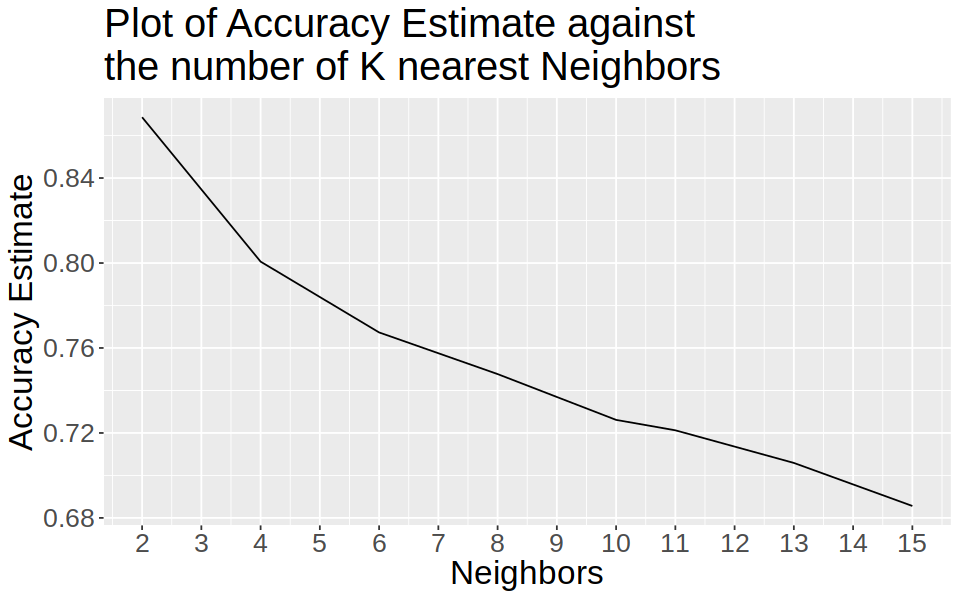

In [181]:
set.seed(1311)
#Plotting predicted accuracies to choose optimal number of neighbors

accuracies <- knn_results |> 
              filter(.metric == "accuracy")

accuracies_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
                   geom_line() +
                   labs(x = "Neighbors", y = "Accuracy Estimate", title = "Plot of Accuracy Estimate against
the number of K nearest Neighbors") +
                   scale_x_continuous(breaks = seq(0, 100, by = 1)) +  
                   theme(text = element_text(size = 20)) 

accuracies_plot

Using 2 neighbours

In [184]:
set.seed(1234)

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
             set_engine("kknn") |>
             set_mode("classification")

wine_fit <- workflow()|>
            add_recipe(wine_recipe)|>
            add_model(wine_spec)|>
            fit(data = wine_training)
wine_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1611111
Best kernel: rectangular
Best k: 2

## Testing on testing data

In [185]:
wine_predictions <- wine_fit|>
                    predict(wine_testing)|>
                    bind_cols(wine_testing)|>
                    metrics(truth = quality, estimate = .pred_class)|>
                    filter(.metric == "accuracy")
wine_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8947368


Findings : accuracy is too low so these 3 alone cant classify wine reliably, the probelm is also the data since it is very unbalanced, almost no observations for 3 and almnost the name sumber of observations for 5 and 6. Maybe this question can still hold true but we would need more balanced data or to pursue oversampling of the less prevelant qualities. Infact the findings of the model are opposite as shown in the 3 scatter plots above. We are getting such biased reaults because 

a) levels of these indicators are pretty much the same

b) there isn't much observational variety

c) one solution is to group qualities together into an interval like [3,5), (5,7), [7, 9]

THESE ARE FOR OLD ONE WITH LOW ACCURACY